In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from IPython.display import display, HTML
import plotly.express as px

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

/Users/susierwu/miniconda3/envs/ar6/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#from utils.majorghg_modA import *
#from utils.majorghg_modB_whRF import * 
from utils.minorghg_modAB_combined import *

# A. first run FAIR model, as output parameters of fair will be used as input for calculating d-GWP

## 1. Create FaIR instance

To reproduce an AR6-like run, we want to allow methane lifetime to be affected by all its relevant chemical precursors (NOx, VOCs, etc) so we set the `ch4_method` flag to `Thornhill2021` (see https://docs.fairmodel.net/en/latest/api_reference.html#fair.FAIR for all of the options for initialising `FAIR`).

In [3]:
f = FAIR(ch4_method="Thornhill2021")

## 2. Define time horizon

A lot of analysis uses 2100 as the time horizon, but 2300 is an interesting end point to see the effects of long-term climate change. We'll set 2300 as the last time bound, so the last emissions time point is 2299.5. We could even run to 2500, as the scenarios are defined that far.

In [4]:
f.define_time(2000, 2500, 1)  # start=1750(baselinE), end=2300, step

## 3. Define scenarios

Since the eight tier 1 & tier 2 SSPs are shipped with RCMIP, and they are quite familiar, we'll use these scenarios. We'll use the `fill_from_rcmip()` function from FaIR, so these have to use the same scenario names that appear in the RCMIP database.

In [5]:
scenarios = ["ssp119", "ssp126", "ssp245",  "ssp585"]
#scenarios = ["ssp119", "ssp126", "ssp245", "ssp370", "ssp434", "ssp460", "ssp534-over", "ssp585"]

In [6]:
f.define_scenarios(scenarios)

## 4. Define configs

In [7]:
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/8399112/files/calibrated_constrained_parameters.csv',
    known_hash = 'md5:de3b83432b9d071efdd1427ad31e9076',
)

In [8]:
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

In [9]:
#df_configs.head()

## 5. Define species and properties

We will use FaIR's default list of 63 species. They are often run with default properties that are included in the model code. However, as part of the v1.1 calibration, some defaults are modified, such as the sensitivity of chemical precursors to methane lifetime. Rather than manually overriding this by setting `species_configs`, it is cleaner to modify the defaults in the CSV file that is read in to define the `species` and `properties`. 

In fact, as this only reads in and defines `species` and `properties` (not `species_configs`), the default (no `filename`) argument could be used here, but it is good practice in my opinion to put species, properties and configs in the same file, and to use the same file to read in `properties` and `species_configs`.

If you're following along at home, feel free to insert a new cell after this one and inspect what the `species` and `properties` actually are.

In [10]:
#https://github.com/OMS-NetZero/FAIR/blob/master/examples/data/species_configs_properties_calibration1.2.0.csv 
#saved to 'data/ ... 
species, properties = read_properties(filename='data/species_configs_properties_calibration1.2.0.csv')
f.define_species(species, properties)

In [11]:
#properties

## 6. Modify run options

Not necessary, as we made all of our choices on initialisation (step 1).

## 7. Create input and output xarrays

If this runs without error, the problem is consistently and completely set up: we then just need to add data.

In [12]:
f.allocate()

## 8. Fill in data

### 8a. emissions, solar forcing, and volcanic forcing

We can use the convenience function `fill_from_rcmip()` to fill in the emissions. Remember that not all `species` are things that take emissions, so if you see NaNs below, don't panic.

In [13]:
f.fill_from_rcmip()

In [14]:
#f.emissions

There is an issue with the RCMIP NOx emissions; the units are different for biomass burning emissions (Tg NO/yr) to the other emissions from fossil fuels, industry and agriculture (Tg NO2/yr). v1.1 of the calibration uses the corrected NOx emissions expressed in Tg NO2/yr, so we also have to correct them in FaIR for consistency.

We download the RCMIP emissions file, and pull out the relevant sectors, update the unit, and finally override the correct entry of `f.emissions`.

Notes on the below:

- 46.006 is the molecular weight of NO2 (g/mol).
- 30.006 is the molecular weight of NO (g/mol).
- The final `[:550, None]` is to transfer the data coming in from RCMIP (dimension (750,), a timeseries of annual emissions) into the correct shape for our problem (550, 1001). Since we are looping over the `scenario` dimension and selecting it, and we are selecting NOx from the `species` dimension, these axes are collapsed and we're left with (`timepoints`, `configs`). The RCMIP data starts in 1750 as does our emissions data; if there is a mismatch in the start date, it would be necessary to select the correct slice from the RCMIP `DataFrame` that is loaded in. For a reminder of the dimensioning in FaIR 2.1, see https://docs.fairmodel.net/en/latest/intro.html#dimensionality.

In [15]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
df_emis = pd.read_csv(rcmip_emissions_file)
gfed_sectors = [
    "Emissions|NOx|MAGICC AFOLU|Agricultural Waste Burning",
    "Emissions|NOx|MAGICC AFOLU|Forest Burning",
    "Emissions|NOx|MAGICC AFOLU|Grassland Burning",
    "Emissions|NOx|MAGICC AFOLU|Peat Burning",
]
for scenario in scenarios:
    f.emissions.loc[dict(specie="NOx", scenario=scenario)] = (
        df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"].isin(gfed_sectors)),
            "2000":"2500",       #change back to 2300 as default
        ]
        .interpolate(axis=1)
        .values.squeeze()
        .sum(axis=0)
        * 46.006
        / 30.006
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC AFOLU|Agriculture"),
            "2000":"2500",
        ]
        .interpolate(axis=1)
        .values.squeeze()
        + df_emis.loc[
            (df_emis["Scenario"] == scenario)
            & (df_emis["Region"] == "World")
            & (df_emis["Variable"] == "Emissions|NOx|MAGICC Fossil and Industrial"),
            "2000":"2500",
        ]
        .interpolate(axis=1)
        .values.squeeze()
    )[:500, None]  # 550 if ending year 2300 and starting 1750, 

Now we fetch and fill in the solar and volcanic forcing. As these are forcing-driven time series, if we want to vary the uncertainties in the forcing, this has to happen before FaIR is run (see https://github.com/OMS-NetZero/FAIR/issues/126).

In [16]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [17]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

#### <font color = "red">df_solar only has data 1750 - up tp 2300 </font>

In [18]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj)

Remembering that everything that is not emissions is on `timebounds`, there is always one more `timebounds` than `timepoints`, so we define arrays of length 551 (1750 to 2300, inclusive).

Volcanic forcing is given monthly, so we average the 12 previous months for each `timebounds` volcanic forcing.

Volcanic forcing here follows the CMIP6 ScenarioMIP convention of a 10 year ramp down to zero from the last year of data (here 2019). Again a little bit of ninja skill with indexing is needed.

In [19]:
l = 501 # since we change ending year to 2500, AND starting year to 2000 here we need new array.dim to (751,1001)

solar_forcing = np.zeros(l)
volcanic_forcing = np.zeros(l)
volcanic_forcing[:352] = df_volcanic.erf.values
solar_forcing[:301] = df_solar["erf"].loc[2000:2300].values

trend_shape = np.ones(l)
trend_shape[:271] = np.linspace(0, 1, 271) 

We then use our calibrated, constrained ensemble to individually scale the volcanic forcing time series, and the solar amplitude and trend:

In [20]:
fill(
    f.forcing,
    volcanic_forcing[:, None, None] * df_configs["fscale_Volcanic"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    solar_forcing[:, None, None] * df_configs["fscale_solar_amplitude"].values.squeeze()
    + trend_shape[:, None, None] * df_configs["fscale_solar_trend"].values.squeeze(),
    specie="Solar",
)

### 8b. Fill in climate_configs

This is relatively straightforward from the calibrated, constrained dataset.

In [21]:
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "clim_c1":"clim_c3"].values)
fill(
    f.climate_configs["ocean_heat_transfer"],
    df_configs.loc[:, "clim_kappa1":"clim_kappa3"].values,
)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["clim_epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["clim_gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["clim_sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["clim_sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["clim_F_4xCO2"])

### 8c. Fill in species_configs

Firstly we want to get the defaults from our new species/properties/configs file

In [22]:
f.fill_species_configs(filename='data/species_configs_properties_calibration1.2.0.csv')

Then, we overwrite the `species_configs` that are varies as part of the probablistic sampling. This makes heavy use of the `fill()` convenience function.

In [23]:
# carbon cycle
fill(f.species_configs["iirf_0"], df_configs["cc_r0"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_airborne"], df_configs["cc_rA"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_uptake"], df_configs["cc_rU"].values.squeeze(), specie="CO2")
fill(f.species_configs["iirf_temperature"], df_configs["cc_rT"].values.squeeze(), specie="CO2")

# aerosol indirect
fill(f.species_configs["aci_scale"], df_configs["aci_beta"].values.squeeze())
fill(f.species_configs["aci_shape"], df_configs["aci_shape_so2"].values.squeeze(), specie="Sulfur")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_bc"].values.squeeze(), specie="BC")
fill(f.species_configs["aci_shape"], df_configs["aci_shape_oc"].values.squeeze(), specie="OC")

# aerosol direct
for specie in [
    "BC", 
    "CH4", 
    "N2O",
    "NH3", 
    "NOx",
    "OC", 
    "Sulfur", 
    "VOC",
    "Equivalent effective stratospheric chlorine"
]:
    fill(f.species_configs["erfari_radiative_efficiency"], df_configs[f"ari_{specie}"], specie=specie)

# forcing scaling
for specie in [
    "CO2", 
    "CH4", 
    "N2O", 
    "Stratospheric water vapour",
    "Contrails", 
    "Light absorbing particles on snow and ice", 
    "Land use"
]:
    fill(f.species_configs["forcing_scale"], df_configs[f"fscale_{specie}"].values.squeeze(), specie=specie)
# the halogenated gases all take the same scale factor
for specie in [
    "CFC-11",
    "CFC-12",
    "CFC-113",
    "CFC-114",
    "CFC-115",
    "HCFC-22",
    "HCFC-141b",
    "HCFC-142b",
    "CCl4",
    "CHCl3",
    "CH2Cl2",
    "CH3Cl",
    "CH3CCl3",
    "CH3Br",
    "Halon-1211",
    "Halon-1301",
    "Halon-2402",
    "CF4",
    "C2F6",
    "C3F8",
    "c-C4F8",
    "C4F10",
    "C5F12",
    "C6F14",
    "C7F16",
    "C8F18",
    "NF3",
    "SF6",
    "SO2F2",
    "HFC-125",
    "HFC-134a",
    "HFC-143a",
    "HFC-152a",
    "HFC-227ea",
    "HFC-23",
    "HFC-236fa",
    "HFC-245fa",
    "HFC-32",
    "HFC-365mfc",
    "HFC-4310mee",
]:
    fill(f.species_configs["forcing_scale"], df_configs["fscale_minorGHG"].values.squeeze(), specie=specie)

# ozone
for specie in ["CH4", "N2O", "Equivalent effective stratospheric chlorine", "CO", "VOC", "NOx"]:
    fill(f.species_configs["ozone_radiative_efficiency"], df_configs[f"o3_{specie}"], specie=specie)

# initial value of CO2 concentration (but not baseline for forcing calculations)
fill(
    f.species_configs["baseline_concentration"], 
    df_configs["cc_co2_concentration_1750"].values.squeeze(), 
    specie="CO2"
)

### 8d. Initial conditions

It's important these are defined, as they are NaN by default, and it's likely you'll run into problems.

In [24]:
#f.species_configs["baseline_concentration"]
#f.species_configs["baseline_concentration"]    #.loc()

In [25]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## 9. Run

In [26]:
f.run()

Running 4004 projections in parallel: 100%|█| 500/500 [01:13<00:00,  6.77timeste


# B. prepare minorGHGs for their metric calculation 

### 1. get all 41 minorGHGs 

In [ ]:
species
#properties

In [ ]:
properties

In [27]:
properties['CO2']['greenhouse_gas']

True

In [28]:
allminorghg = []
for sp in species:
    if properties[sp]['greenhouse_gas'] == True: 
        #print(sp)
        if sp in ["CO2", "CH4", "N2O"]:
            pass
        else:
            allminorghg.append(sp)

In [29]:
allminorghg

['CFC-11',
 'CFC-12',
 'CFC-113',
 'CFC-114',
 'CFC-115',
 'HCFC-22',
 'HCFC-141b',
 'HCFC-142b',
 'CCl4',
 'CHCl3',
 'CH2Cl2',
 'CH3Cl',
 'CH3CCl3',
 'CH3Br',
 'Halon-1202',
 'Halon-1211',
 'Halon-1301',
 'Halon-2402',
 'CF4',
 'C2F6',
 'C3F8',
 'c-C4F8',
 'C4F10',
 'C5F12',
 'C6F14',
 'C7F16',
 'C8F18',
 'NF3',
 'SF6',
 'SO2F2',
 'HFC-125',
 'HFC-134a',
 'HFC-143a',
 'HFC-152a',
 'HFC-227ea',
 'HFC-23',
 'HFC-236fa',
 'HFC-245fa',
 'HFC-32',
 'HFC-365mfc',
 'HFC-4310mee']

In [30]:
# if we only wanna some minorghg:
to_calc_gas = ['CFC-11', 'HFC-236fa']

### 2. check alpha and RE  
#### check lifetime for all minorGHG: same fixed-point value per SSP[x], MY[t], use [ scale_f * un_pert_liftime] in our model for each gas

In [31]:
for gas in allminorghg: 
    for sp in ['ssp119', 'ssp585']: 
        for y_index in [0, 236, 400]:
            fs = f.alpha_lifetime.loc[dict(scenario=sp, specie=gas)][y_index].values
            fs2 = f.species_configs['unperturbed_lifetime'].loc[dict(specie=gas, gasbox=0)].data 
            print(f" for gas {gas}, SSP {sp}, MY {y_index}, scaling_factor: {fs}, un_pert_liftime: {fs2} "   )


 for gas CFC-11, SSP ssp119, MY 0, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [52. 52. 52. ... 52. 52. 52.] 
 for gas CFC-11, SSP ssp119, MY 236, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [52. 52. 52. ... 52. 52. 52.] 
 for gas CFC-11, SSP ssp119, MY 400, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [52. 52. 52. ... 52. 52. 52.] 
 for gas CFC-11, SSP ssp585, MY 0, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [52. 52. 52. ... 52. 52. 52.] 
 for gas CFC-11, SSP ssp585, MY 236, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [52. 52. 52. ... 52. 52. 52.] 
 for gas CFC-11, SSP ssp585, MY 400, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [52. 52. 52. ... 52. 52. 52.] 
 for gas CFC-12, SSP ssp119, MY 0, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [102. 102. 102. ... 102. 102. 102.] 
 for gas CFC-12, SSP ssp119, MY 236, scaling_factor: [1. 1. 1. ... 1. 1. 1.], un_pert_liftime: [102. 102. 102. ... 102

In [32]:
for gs in to_calc_gas:
    for sp in  ["ssp126","ssp245","ssp585"]: 
        for yy in [20,60,150]:
            xx36 = minorghg_get_f_anal_metric(f, minorghg = gs, scn = sp, year_index = yy )
            gasf = xx36.call_f_from_fair_minorgas()
            print(sp, yy)
            print(f" for gas {gs}, {gasf['gas_lifetime']} " ) 

ssp126 20
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp126 60
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp126 150
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp245 20
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp245 60
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp245 150
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp585 20
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp585 60
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp585 150
 for gas CFC-11, [52.00000005 52.00000005 52.00000005 ... 52.00000005 52.00000005
 52.00000005] 
ssp126 20
 for gas HFC-236fa, [212

#### check and plot RE same for all minorghg, per SSP[x] MY[t]

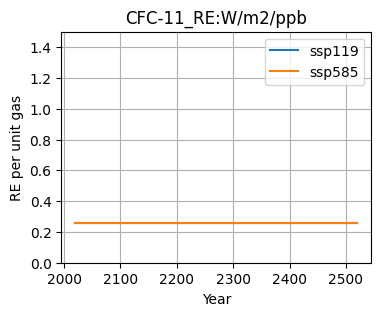

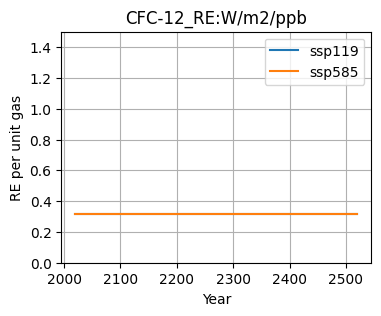

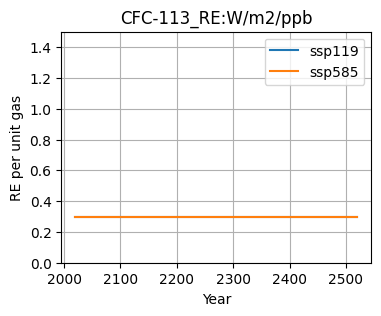

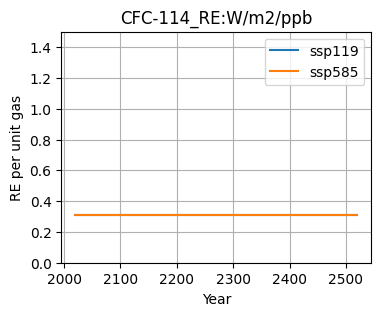

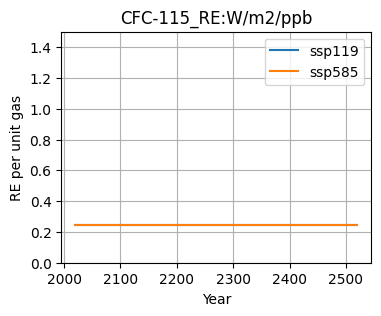

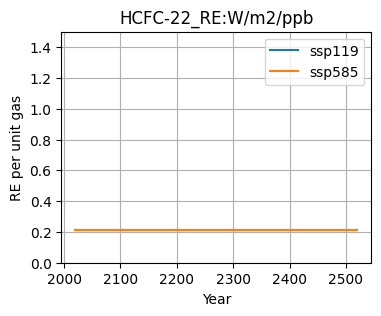

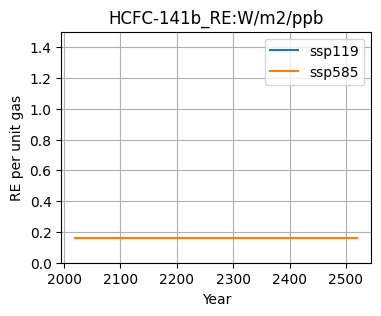

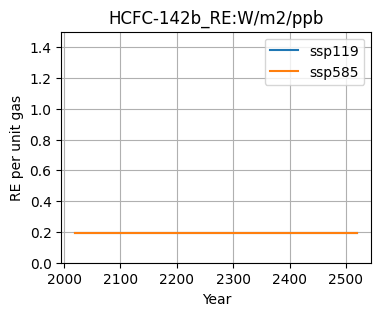

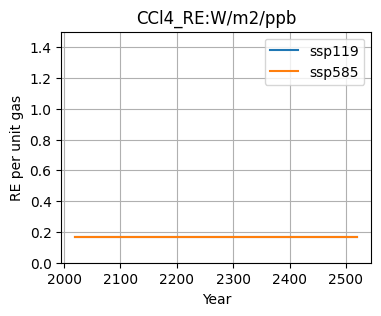

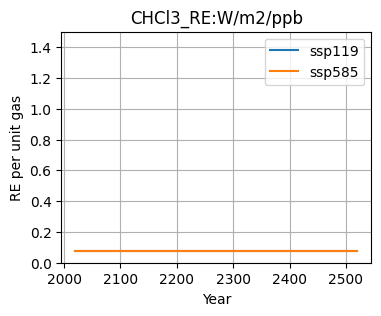

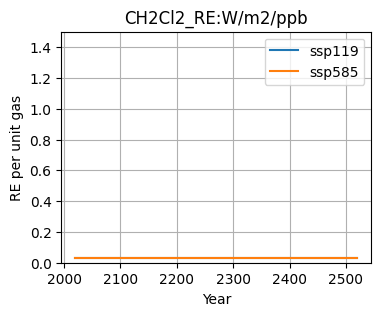

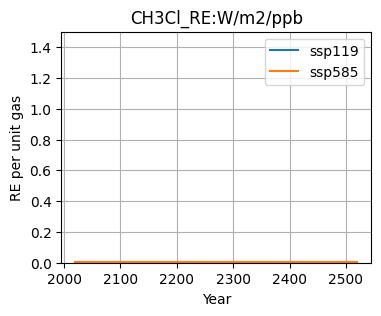

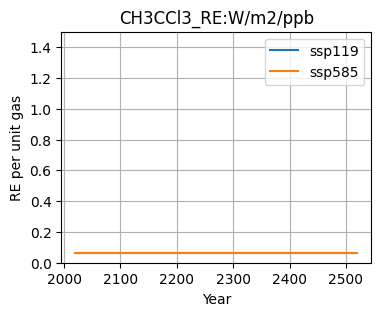

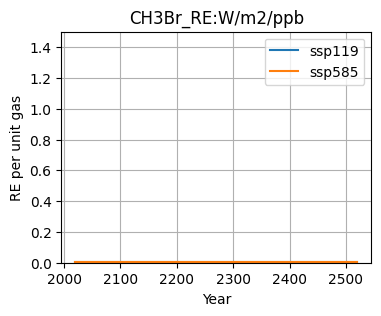

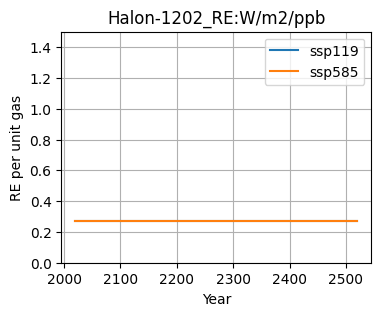

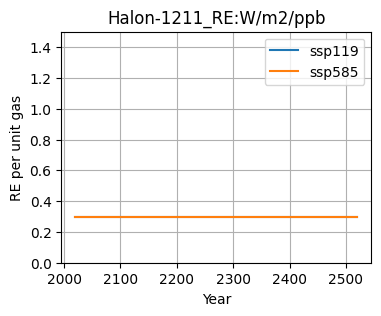

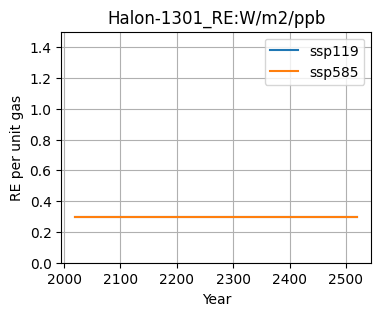

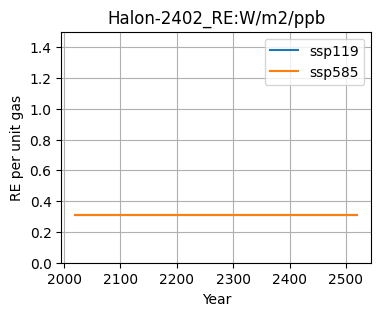

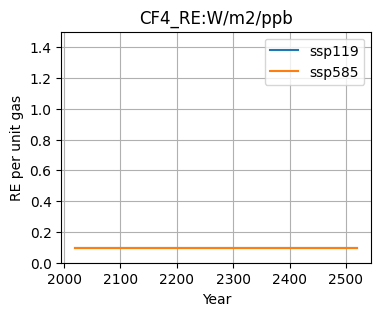

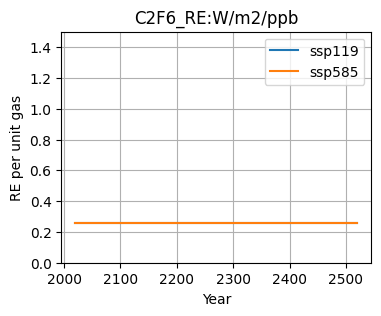

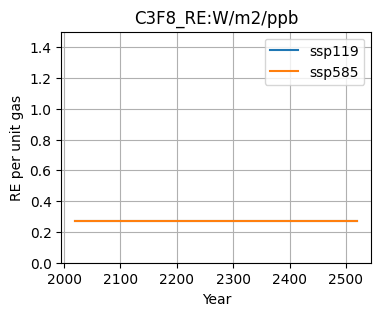

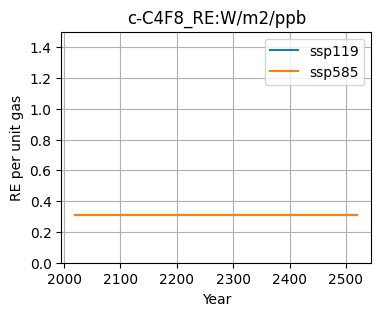

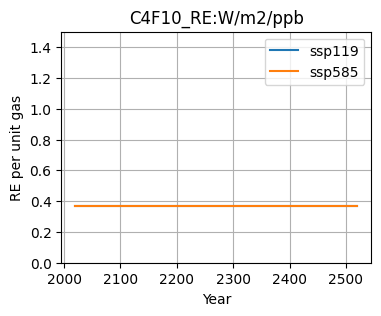

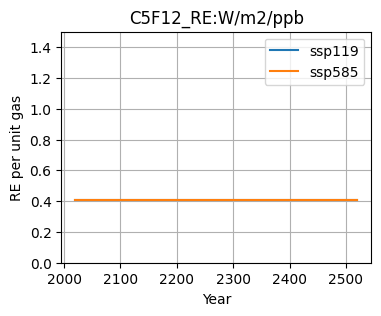

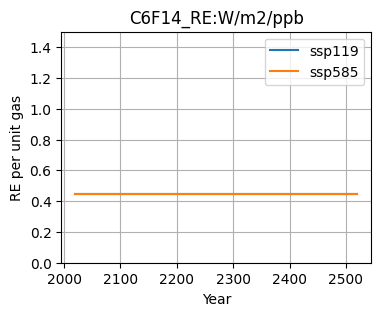

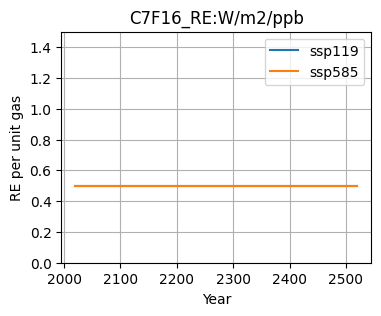

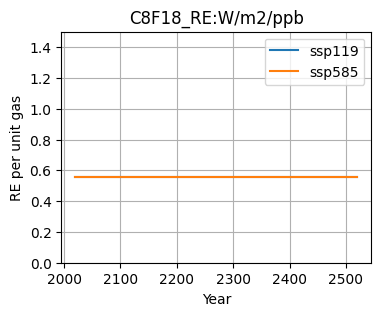

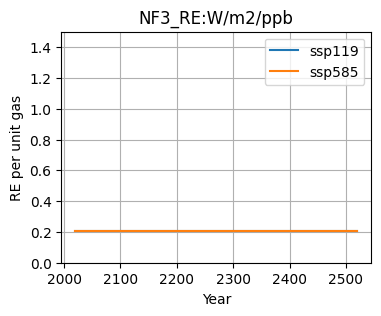

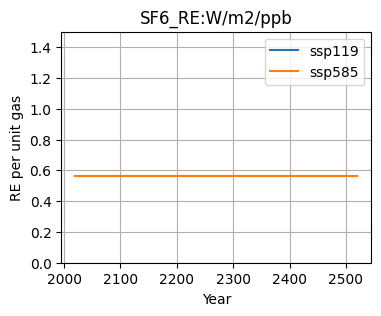

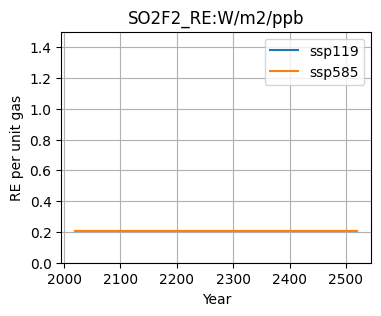

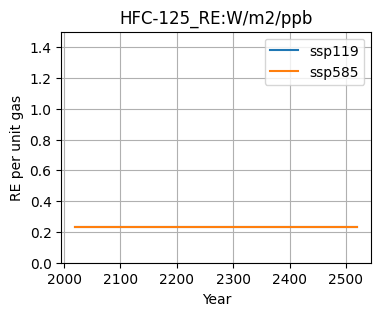

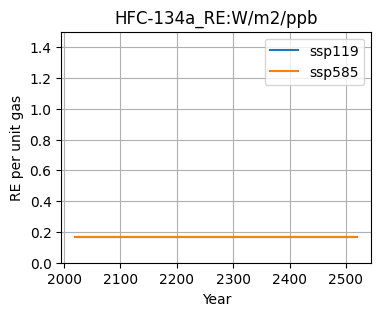

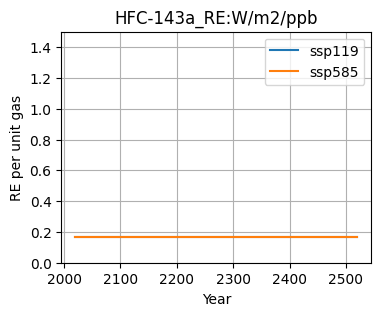

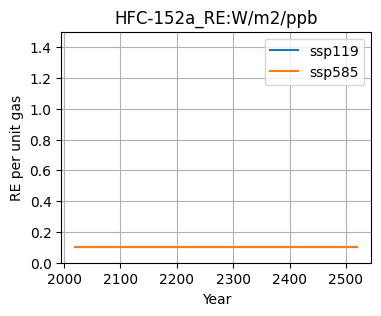

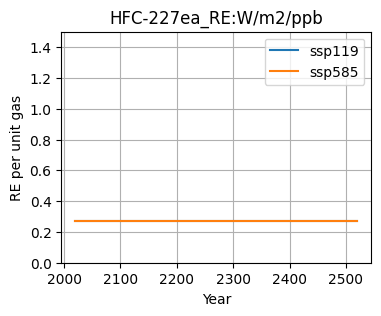

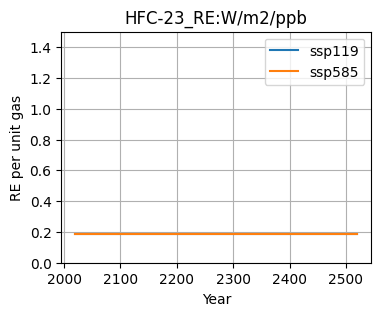

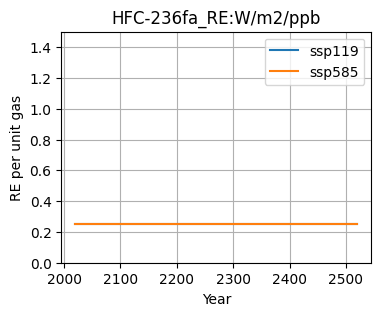

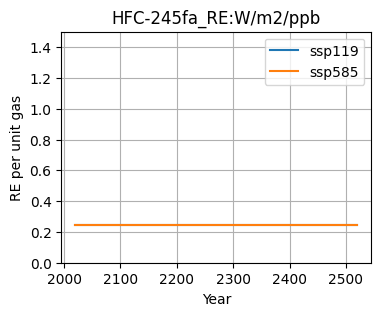

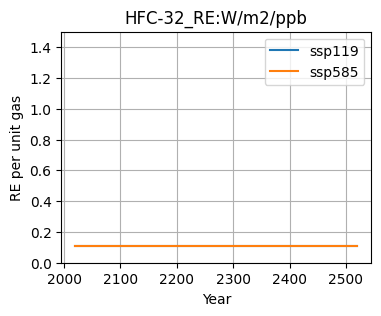

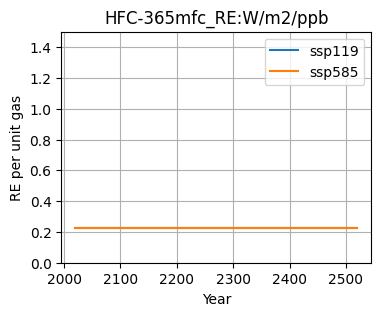

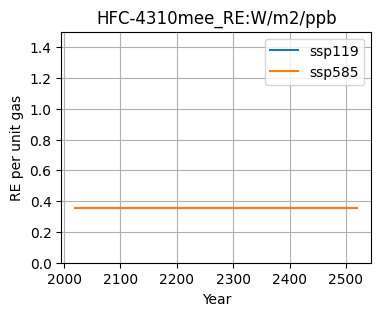

In [33]:
col_ssp=  ["ssp119","ssp585"]
hm = 20

for gg in allminorghg: 
    gas_re_ssp1001 = []
    for x in col_ssp: 
        xx36 = minorghg_get_f_anal_metric(f = f, H_max=hm, minorghg = gg, scn = x, year_index = 20 )
        gas_re = xx36.get_minorghg_1ppb_erf()
        tt = gg + '_RE:W/m2/ppb'
        gas_re_ssp1001.append(gas_re)
        #check if RE is same for all ModelYear 
        #print( np.all(gas_re == gas_re[0, :], axis=0).all() ) 
         
    # from above fair 1001 ensmb, get single RE value for each year 
    gas_re_ssp_single = [] 
    for i in range(len(gas_re_ssp1001)):
        single_re = []
        for x in gas_re_ssp1001[i]:
            x_md = np.median(x)
            single_re.append(x_md)
        gas_re_ssp_single.append(single_re)
        
    gas_re_df = pd.DataFrame(zip(*gas_re_ssp_single), columns = col_ssp)
    
    fig = plt.figure(figsize=(4, 3))
    for column in gas_re_df.columns:
        plt.plot(gas_re_df.index+ 2000+ hm, gas_re_df[column], label=column)
    plt.xlabel('Year')
    plt.ylabel('RE per unit gas')
    plt.ylim(0, 1.5)
    plt.title( tt)
    plt.legend()
    plt.grid(True)
    plt.show()

## 3. final metric calculation and save to excel

#### wh1001 here, if only wanna point value, set  metric_wh1001 = False

In [34]:
for gg in allminorghg: 
    for sp in ["ssp119","ssp585"]: 
        hh36 = minorghg_get_f_anal_metric(f, minorghg = gg, scn = sp,  H_max = 20, fair_start_y = 2000, year_index = 30 )
        gasf = hh36.call_f_from_fair_minorgas()
        re_1001 =  hh36.get_minorghg_1ppb_erf()
        rf  = hh36.minorghg_analytical(gas_erf_diff = re_1001)[0]
        agwp  = hh36.minorghg_analytical(gas_erf_diff = re_1001)[1] 
        #print(rf.shape, agwp.shape)
        print(f"for SSP {sp}, minorgas {gg} AGWP20: {np.median(agwp[20], axis=0)}  ")

for SSP ssp119, minorgas CFC-11 AGWP20: 1.754791609097117e-10  
for SSP ssp585, minorgas CFC-11 AGWP20: 1.754791609097117e-10  
for SSP ssp119, minorgas CFC-12 AGWP20: 2.6898120316597026e-10  
for SSP ssp585, minorgas CFC-12 AGWP20: 2.6898120316597026e-10  
for SSP ssp119, minorgas CFC-113 AGWP20: 1.6201452715425168e-10  
for SSP ssp585, minorgas CFC-113 AGWP20: 1.6201452715425168e-10  
for SSP ssp119, minorgas CFC-114 AGWP20: 1.9532630443877834e-10  
for SSP ssp585, minorgas CFC-114 AGWP20: 1.9532630443877834e-10  
for SSP ssp119, minorgas CFC-115 AGWP20: 1.7518837785000814e-10  
for SSP ssp585, minorgas CFC-115 AGWP20: 1.7518837785000814e-10  
for SSP ssp119, minorgas HCFC-22 AGWP20: 1.3402819173158355e-10  
for SSP ssp585, minorgas HCFC-22 AGWP20: 1.3402819173158355e-10  
for SSP ssp119, minorgas HCFC-141b AGWP20: 6.365623106843277e-11  
for SSP ssp585, minorgas HCFC-141b AGWP20: 6.365623106843277e-11  
for SSP ssp119, minorgas HCFC-142b AGWP20: 1.2997815193926754e-10  
for SSP ssp5

### 4. final calc with GWP, saving to excel

In [36]:
for gg in allminorghg:
    # didn't run other SSP, RE / alpha same among SSPs for minorGHG, self-AGWP is same, CO2-AGWP will be different 
    # run self_AGWP only for one SSP, then save it and add another loop for all other SSPs to fetch CO2-AGWP
    for sp in ["ssp119"]:
        for my in [30]:  # MY=2030
            hh36 = minorghg_get_f_anal_metric(f, minorghg = gg, scn = sp,  H_max = 100, fair_start_y = 2000, year_index = my )
            gasf = hh36.call_f_from_fair_minorgas()
            re_1001 =  hh36.get_minorghg_1ppb_erf()
            rf  = hh36.minorghg_analytical(gas_erf_diff = re_1001)[0]
            agwp  = hh36.minorghg_analytical(gas_erf_diff = re_1001)[1] 
            # calculate gwp (wh 1001 then save RF/AGWP/GWP to excel)
            gwp = hh36.get_minorghg_GWP(agwp, agwp_co2_folder = "output/metrics/")
            print(f"for SSP {sp}, minorgas {gg}, year {2000+my}, AGWP100: {np.median(agwp[100], axis=0)}  ")
            print(f"GWP100:  {np.median(gwp[100], axis=0)}")
            # saving to output/metrics 
            hh36.get_dcf_finaloutput_minorghg(rf, agwp, gwp)

final dims of AGWP for assessed minorGHG and CO2 is:  (101, 1001) (101, 1001)
for SSP ssp119, minorgas CFC-11, year 2030, AGWP100: 4.692688666662474e-10  
GWP100:  4581.919587590564
calculated metric saved to output/metrics/minorGHG_2024-08-08/agwp_dcf_gwp100_tstep1CFC-11_ssp119_fair_start2000MY2030.xlsx
final dims of AGWP for assessed minorGHG and CO2 is:  (101, 1001) (101, 1001)
for SSP ssp119, minorgas CFC-12, year 2030, AGWP100: 9.43931729815516e-10  
GWP100:  9216.505908255727
calculated metric saved to output/metrics/minorGHG_2024-08-08/agwp_dcf_gwp100_tstep1CFC-12_ssp119_fair_start2000MY2030.xlsx
final dims of AGWP for assessed minorGHG and CO2 is:  (101, 1001) (101, 1001)
for SSP ssp119, minorgas CFC-113, year 2030, AGWP100: 5.515924313585866e-10  
GWP100:  5385.723079315424
calculated metric saved to output/metrics/minorGHG_2024-08-08/agwp_dcf_gwp100_tstep1CFC-113_ssp119_fair_start2000MY2030.xlsx
final dims of AGWP for assessed minorGHG and CO2 is:  (101, 1001) (101, 1001)
for